# Predict the Next Word: Word-Level Language Modelling

In this notebook, we will build a word-level language model for predicting the next word given a sequence of words.

We use a text dataset called <a href="https://catalog.ldc.upenn.edu/docs/LDC95T7/cl93.html">Penn Tree Bank (PTB) dataset</a> to train, validate and test the language model. Penn Treebank (PTB) dataset, is widely used in machine learning for NLP (Natural Language Processing) research. Word-level PTB does not contain capital letters, numbers, and punctuations, and the vocabulary is capped at 10k unique words, which is relatively small in comparison to most modern datasets which can result in a larger number of out of vocabulary tokens. 

## Setting-Up 1: Mount Google Drive to the notebook
 
You can easily load data from Google Drive by mounting it to the notebook. To do this, type the following code in your notebook. Run it, you will see a link, and need enter some code. To get the code, you need first click the link. In the link, after logining to your Google Account, you will see a code. Copy it, and paste it here. 

Then you will see "Mounted at /content/drive" -- done!

Now you will see your Google Drive files in the left pane (file explorer). Right click on the file and select 'Copy path'. Your file's full path will be like `/content/gdrive/MyDrive/Colab Notebooks/dogs_vs_cats.ipynb`. 

Your current directory will be `/content/`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting-Up 2: One click to enable FREE GPU 
After you mounted your Google Drive and downloaded the dataset, let’s enable GPU in your Colab notebook and train your model. In Google Colab, it is very easy to do so. 

From task bar, click: Runtime ⇨ Change runtime type

Choose 'GPU' in the Hardware accelerator.

## Setting data path
You need first upload the three txt files to your Google Drive. Then  change the `data_path` variable to match the location of this downloaded data.

In [2]:
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np

data_path = '/content/drive/MyDrive/Colab Notebooks/data/PTB/' # change the data_path

## STEP 1: Preparing the data
In order to get the text data into the right shape for input into the Keras LSTM model, each unique word in the corpus must be assigned a unique integer index. Then the text corpus needs to be re-constituted in order, but rather than text words we have the integer identifiers in order. The three functions which do this in the code are `read_words()`, `build_vocab()` and `file_to_word_ids()`. See the comments for explanation. 

Then we call the `load_data()` function to run these functions. 

In [3]:
"""
Split the given text file into separate words and sentence based characters 
(i.e. end-of-sentence <eos>).
"""
def read_words(filename):
    with tf.io.gfile.GFile(filename, "r") as f:
        return f.read().replace("\n", "<eos>").split()

"""
Build a vocabulary: each unique word is identified and assigned a unique integer.
In natual langage processing, not all words are 
put into the vocabulary -  rather, usually 
limited to a certain N number of most common words. 
More frequent the word appears, the smaller number it is represented. 
""" 
def build_vocab(filename):
    data = read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))

    return word_to_id

"""
Convert the original text file into a list of those unique integers, 
where each word is substituted with its new integer identifier.
This allows the text data to be consumed in the neural network.
"""
def file_to_word_ids(filename, word_to_id):
    data = read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]


def load_data():
    # get the data paths
    train_path = os.path.join(data_path, "ptb.train.txt")
    valid_path = os.path.join(data_path, "ptb.valid.txt")
    test_path = os.path.join(data_path, "ptb.test.txt")

    # build the complete vocabulary, then convert text data to list of integers
    word_to_id = build_vocab(train_path)
    train_data = file_to_word_ids(train_path, word_to_id)
    valid_data = file_to_word_ids(valid_path, word_to_id)
    test_data = file_to_word_ids(test_path, word_to_id)
    size_vocabulary = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))

    print("Vocabulary size: %d " % size_vocabulary)
    # Disply the first 10 training data, they must be 10 integer numbers 
    print(train_data[100:110]) 
    # convert the integer numbers back into words
    print(" ".join([reversed_dictionary[x] for x in train_data[100:110]]))
    return train_data, valid_data, test_data, size_vocabulary, reversed_dictionary

# Load the data
train_data, valid_data, test_data, size_vocabulary, reversed_dictionary = load_data()

Vocabulary size: 10000 
[431, 4115, 5, 14, 45, 55, 3, 72, 195, 1244]
workers exposed to it more than N years ago researchers


## STEP 2: Data generator for progressive data loading

Instead of loading all the training and validation data in memory, it is more feasible to loading the data *progressively*.

When training neural networks, we generally feed data into them in small batches. Keras has some handy functions which can extract training data automatically from a pre-supplied Python iterator/generator object and input it to the model. One of these Keras functions is called `fit_generator`. 

In this case, we create a generator class `KerasBatchGenerator` that contains a method `generate()` to implement such a structure. 

The `num_steps` is the input sequence length. The `skip_steps` is the number of words we want to skip over between training samples within each batch. To make this a bit clearer, consider the following sentence: “*The cat sat on the mat, and ate his hat. Then he jumped up and spat*”. Suppose `num_steps=5` and `skip_steps=3`, then the first sequence would be “*The cat sat on the*”, and the second would be "*on the mat and ate*". Therefore, if `skip_steps=num_steps`, there would be no overlap between the succesive sequences. 

The variable `y` is the target word label (or category label) for each input variabel `x`. You may notice that the variable `y`'s third dimension is the size of the vocabulary, in this case, 10,000. This is because it is a one-hot representation, i.e., only one of the elementes in each vector is 1, the rest is 0, like this: (0, 0, 0, …, 1, 0, …, 0, 0). Keras offers a `to_categorical()` function to do such transformations.

We then get both the generated training data and validation data by initiating two instances of the class `KerasBatchGenerator`.

In [4]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, size_vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps # the input sequence length
        self.batch_size = batch_size
        self.size_vocabulary = size_vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.size_vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                # convert all of temp_y into a one hot representation
                y[i, :, :] = to_categorical(temp_y, num_classes=self.size_vocabulary)
                self.current_idx += self.skip_step
            yield x, y

            
num_steps = 30
batch_size = 20
print("* Generate training and validation data ...")
train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, size_vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, size_vocabulary,
                                           skip_step=num_steps)

* Generate training and validation data ...


## STEP 3: Build the LSTM model

The full model architecutre looks like the following. 

<img src="https://drive.google.com/uc?id=15mKswIuW3CZOKghPF6eYDQSYZcvptVc0">

### Embedding layer

Before we add the LSTM network, we need first convert our words (referenced by integers in the data) into meaningful embedding vectors - called **word embedding**. Here, we set `embedding_size` to be 500, means each word will be transformed into a 500 length vector. These embedding vectors will be learnt as part of the overall model learning. (As mentioned in the previous example, you could choose to use *pre-trained word embedding*.)

The `Embedding()` layer takes the size of the vocabulary as its first argument (`input_dim`), then the size of the embedding vector as the second argument (`output_dim`). Also we need specify the `input_length` which is the length of input sequences, i.e. the number of steps/words in each sample. 

After word embedding, the input data for LSTM is in the shape of (`batch_size`, `num_steps`, `embedding_size`). 

### Stacked LSTM layers

Then we add a stacked LSTM model with two LSTMs. The first argument for `LSTM` layer is the number of nodes for the hidden layer (or the length of hidden state vector). The next argument is the `return_sequences=True` means to return all of the outputs from the unrolled LSTM cell through time. If this argument is left out, the LSTM will simply provide the output vector from the last time step. 

The reason for returning all the output vectors of the first LSTM is because they will be used as inputs for the second LSTM. In this example we are trying to predict the very next word in the sequence, we could set the second `return_sequeces` to be `False`. However, if we compare the LSTM cell output at each time step with the very next word in the sequence – in this way we get `num_steps` sources to correct errors  rather than just one for each sample. Therefore, for both stacked LSTM layers, we want to return all the sequences. 

The output shape of each LSTM layer is (`batch_size`, `num_steps`, `hidden_size`).

### TimeDistributed layer

There is a special Keras layer for use in recurrent neural networks called `TimeDistributed`. This function adds an independent layer for each time step in the recurrent model. So, for instance, if we have 30 time steps in our model, a `TimeDistributed` layer operating on a `Dense` layer would produce 30 independent Dense layers, one for each time step. 

This output layer has a `softmax` activation applied to it, since predicting a word can be considered as a multi-class classification.

In [5]:
print("* Build the two-layer LSTM model ...")
embedding_size = 500
hidden_size = 500

model = Sequential()
model.add(Embedding(size_vocabulary, embedding_size, input_length=num_steps))
model.add(Dropout(0.5))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(size_vocabulary)))
model.add(Activation('softmax'))
model.summary()

* Build the two-layer LSTM model ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 500)           5000000   
_________________________________________________________________
dropout (Dropout)            (None, 30, 500)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 500)           2002000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 500)           2002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 500)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 10000)         5010000   
_________________________________________________________________
activation (Activat

## STEP 4: Compile the model
Once you've completed you model, compile it. 

In this case, we are using `categorical_crossentropy` for loss and and `categorical_accuracy` for metrics, which are usually for multi-class classification. Actually, the word prediction is a multi-class classification problem, as each unique word can be considered as one category. It also explains why we use `softmax` activation function for the last layer.

The optimizer that will be used is the `Adam` optimizer – an effective “all-round” optimizer with adaptive learning rate.

In [6]:
print("* Compile the two-layer LSTM model ...")
optimizer = Adam()
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_accuracy'])

* Compile the two-layer LSTM model ...


## STEP 5: Train the model
Note that the `ModelCheckpoint()` function can include the epoch in its naming of the model, which is good for keeping track of things. The final step in training the Keras LSTM model is to call the aforementioned fit_generator function.

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1549/1549 [==============================] - 137s 83ms/step - loss: 6.8727 - categorical_accuracy: 0.0660 - val_loss: 5.8626 - val_categorical_accuracy: 0.1493
Epoch 2/30
1549/1549 [==============================] - 127s 82ms/step - loss: 5.8346 - categorical_accuracy: 0.1543 - val_loss: 5.4578 - val_categorical_accuracy: 0.1829
Epoch 3/30
1549/1549 [==============================] - 127s 82ms/step - loss: 5.4636 - categorical_accuracy: 0.1790 - val_loss: 5.2642 - val_categorical_accuracy: 0.2021
Epoch 4/30
1549/1549 [==============================] - 127s 82ms/step - loss: 5.2217 - categorical_accuracy: 0.1952 - val_loss: 5.1454 - val_categorical_accuracy: 0.2126
Epoch 5/30
1549/1549 [==============================] - 126s 81ms/step - loss: 5.0448 - categorical_accuracy: 0.2062 - val_loss: 5.0711 - val_categorical_accuracy: 0.2199
Epoch 6/30
1549/1549 [==============================] - 126s 82ms/step - loss: 4.9016 - categorical_accuracy: 0.2160 - val_loss: 5.0243 - val_categorical_ac

Text(0.5, 0, 'epoch')

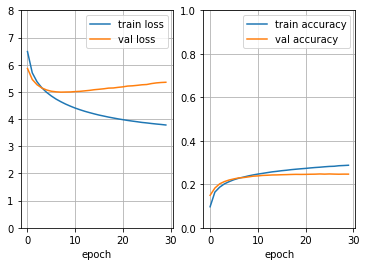

In [7]:
num_epochs = 30
model_file_name = "LSTM-2layer-{}-{}.hdf5".format(num_steps,hidden_size)

history = model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
            validation_data=valid_data_generator.generate(),
            validation_steps=len(valid_data)//(batch_size*num_steps))

model.save(data_path + "/" + model_file_name)
print("*Model is saved.")

import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid(True)
plt.ylim([0,8])##
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label='train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

After 30 epochs, you must see the training data set accuracy was around 28%, while validation set accuracy reached approximately 24.5%. This accuracy looks not as good as what we have seen in previous tasks, such as image classification. But think about it is a 10,000-class classification problem, and also many words are hard to predict, therefore this is not a bad result.  

## STEP 6: Display some predicting examples
Let's display some next-word predicting examples by picking a 30-word sequence to compare the predicted word against what the actual word.  

We first see some examples on the training set.


In [8]:
model_file_name = "LSTM-2layer-{}-{}.hdf5".format(num_steps,hidden_size)
model = load_model(data_path + "/" + model_file_name)

import numpy
print("Prediction example on training set:")
id_start_word = 800 # change it to see other next-word predictions
current_seq_words = "Current sequence: "
for i in range(id_start_word,id_start_word+num_steps):
    current_seq_words += reversed_dictionary[train_data[i]] + " "
actual_word = reversed_dictionary[train_data[id_start_word+num_steps]]
print(current_seq_words)
print("The actual next word: "+actual_word)

current_seq = numpy.array(train_data[id_start_word:id_start_word+num_steps]).reshape(1,num_steps)
print(current_seq.shape)
prediction = model.predict(current_seq)
print(prediction.shape)
predict_word_idx = np.argmax(prediction[:, num_steps-1, :])
predict_word = reversed_dictionary[predict_word_idx]

print("The predicted next word: "+predict_word)

Prediction example on training set:
Current sequence: N N for the week ended tuesday <eos> compound yields assume reinvestment of dividends and that the current yield continues for a year <eos> average maturity of the funds ' 
The actual next word: investments
(1, 30)
(1, 30, 10000)
The predicted next word: investments


The same prediction can be done with the `test_data` as below.

In [9]:
model_file_name = "LSTM-2layer-{}-{}.hdf5".format(num_steps,hidden_size)
model = load_model(data_path + "/" + model_file_name)

import numpy
print("Prediction example on test set:")
id_start_word = 800 # change it to see other next-word predictions
current_seq_words = "Current sequence: "
for i in range(id_start_word,id_start_word+num_steps):
    current_seq_words += reversed_dictionary[test_data[i]] + " "
actual_word = reversed_dictionary[test_data[id_start_word+num_steps]]
print(current_seq_words)
print("The actual next word: "+actual_word)

current_seq = numpy.array(test_data[id_start_word:id_start_word+num_steps]).reshape(1,num_steps)
print(current_seq.shape)
prediction = model.predict(current_seq)
print(prediction.shape)
predict_word_idx = np.argmax(prediction[:, num_steps-1, :])
predict_word = reversed_dictionary[predict_word_idx]

print("The predicted next word: "+predict_word)


Prediction example on test set:
Current sequence: signed by the big board and the chicago mercantile exchange trading was temporarily halted in chicago <eos> after the trading halt in the s&p N pit in chicago waves of 
The actual next word: selling
(1, 30)
(1, 30, 10000)
The predicted next word: the


If you set `id_strat_word` to 800 as what I did, you may see that the predicted word is "the", which does not match the actual word "selling". But if you look at the last word of the input sequence is "of", a "the" is actually a very reasonable prediction.  






*{Opitonal task}* In the last step, I only wrote the code for predicting one word. You may change the code to predict more than one word (e.g., 10 words) using the same model, i.e., run the model prediction 10 times with different input sequences as follows.

- input: [x0, ... x29]      ==> output: the first predicted word y0
- input: [x1, ..., x29, y0] ==> output: the second predicted word y1
- ...
- input: [x9, ..., x29, y0, ..., y8] ==> output the 10-th predicted word y9

## Reference
[1] Blog: <a href=https://adventuresinmachinelearning.com/keras-lstm-tutorial/> Keras LSTM tutorial - How to easily build a powerful deep learning language model</a>